In [87]:
import os, time
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

import skimage
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean

from torchvision import transforms
import torchvision.transforms.functional as TF

import PIL
import imageio

## Define Unet architecture

In [88]:
#from examples.common.example_logger import logger
def make_model():
    return UNet()

class UNetConvBlock(nn.Module):
    def __init__(self, in_size, out_size, padding, batch_norm):
        super(UNetConvBlock, self).__init__()
        block = []

        block.append(nn.Conv2d(in_size, out_size, kernel_size=3,
                               padding=int(padding)))
        if batch_norm:
            block.append(nn.BatchNorm2d(out_size))
        block.append(nn.ReLU())

        block.append(nn.Conv2d(out_size, out_size, kernel_size=3,
                               padding=int(padding)))
        if batch_norm:
            block.append(nn.BatchNorm2d(out_size))
        block.append(nn.ReLU())

        self.block = nn.Sequential(*block)

    def forward(self, x):
        out = self.block(x)
        return out

def center_crop(layer, target_size):
    if layer.dim() == 4:
        # Cropping feature maps
        _, _, layer_height, layer_width = layer.size()
        diff_y = (layer_height - target_size[0]) // 2
        diff_x = (layer_width - target_size[1]) // 2
        return layer[
            :, :, diff_y: (diff_y + target_size[0]), diff_x: (diff_x + target_size[1])
            ]

    # If dimension is not 4, assume that we are cropping ground truth labels
    assert layer.dim() == 3
    _, layer_height, layer_width = layer.size()
    diff_y = (layer_height - target_size[0]) // 2
    diff_x = (layer_width - target_size[1]) // 2
    return layer[
        :, diff_y: (diff_y + target_size[0]), diff_x: (diff_x + target_size[1])
        ]


class UNetUpBlock(nn.Module):
    def __init__(self, in_size, out_size, up_mode, padding, batch_norm):
        super(UNetUpBlock, self).__init__()
        if up_mode == 'upconv':
            self.up = nn.ConvTranspose2d(in_size, out_size, kernel_size=2,
                                         stride=2)
        elif up_mode == 'upsample':
            self.up = nn.Sequential(
                nn.Upsample(mode='bilinear', scale_factor=2),
                nn.Conv2d(in_size, out_size, kernel_size=1),
            )
        self.conv_block = UNetConvBlock(in_size, out_size, padding, batch_norm)
        self.padding = padding

    def forward(self, x, bridge):
        up = self.up(x)
        if self.padding:
            out = torch.cat([up, bridge], 1)
        else:
            crop1 = center_crop(bridge, up.shape[2:])
            out = torch.cat([up, crop1], 1)
        out = self.conv_block(out)

        return out


class UNet(nn.Module):
    def __init__(self):
        """
        Implementation of
        U-Net: Convolutional Networks for Image Segmentation
        Args:
            in_channels (int): number of input channels
            input_size_hw: a tuple of (height, width) of the input images
            n_classes (int): number of output channels
            depth (int): depth of the network
            wf (int): number of filters in the first layer is 2**wf
            padding (bool): if True, apply padding such that the input shape
                            is the same as the output.
                            This may introduce artifacts
            batch_norm (bool): Use BatchNorm prior to layers with an
                               activation function
            up_mode (str): one of 'upconv' or 'upsample'.
                           'upconv' will use transposed convolutions for
                           learned upsampling.
                           'upsample' will use bilinear upsampling.
        """
        super(UNet, self).__init__()

        self.in_channels = 3
        self.n_classes = 1
        self.depth = 4
        self.wf = 6
        self.scale =  1.0

        self.padding = True
        self.batch_norm = True
        self.up_mode='upconv'
        self.down_path = nn.ModuleList()
        self.up_path = nn.ModuleList()

        assert self.up_mode in ('upconv', 'upsample')

        prev_channels = self.in_channels

        for i in range(self.depth):
            new_channels = int((2 ** (self.wf + i)) * self.scale)
            self.down_path.append(
                UNetConvBlock(prev_channels, new_channels, self.padding,
                              self.batch_norm )
            )
            prev_channels = new_channels

        for i in reversed(range(self.depth - 1)):
            new_channels = int((2 ** (self.wf + i)) * self.scale)
            self.up_path.append(
                UNetUpBlock(prev_channels, new_channels, self.up_mode,
                            self.padding, self.batch_norm )
            )
            prev_channels = new_channels

        self.last = nn.Conv2d(prev_channels, self.n_classes, kernel_size=1)

    def forward(self, x):
        blocks = []
        for i, down in enumerate(self.down_path):
            x = down(x)
            if i != len(self.down_path) - 1:
                blocks.append(x)
                x = F.max_pool2d(x, 2)

        for i, up in enumerate(self.up_path):
            x = up(x, blocks[-i - 1])

        x = self.last(x)
        return x


def load(model, pretrain_path, device):
    load_from = None
    kwargs = {}
    if device == torch.device("cpu"):
        kwargs = {'map_location': device}

    load_from = torch.load(
        os.path.join(pretrain_path),
        **kwargs
    )

    print("Load the model from {}".format(pretrain_path))
    model.load_state_dict(load_from)
    return model


## Initialize model and load pretrained weights

In [89]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = make_model()
model = model.to(device)

pretrain_path = "model_best.pt"
model = load(model, pretrain_path, device)
model.eval()

Load the model from model_best.pt


UNet(
  (down_path): ModuleList(
    (0): UNetConvBlock(
      (block): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU()
      )
    )
    (1): UNetConvBlock(
      (block): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU()
      )
    )
    (2): UNetConvBlock(
      (block): Sequential(
        (0): C

#### Define additional functions for inference

In [90]:
def seg_post_process(tensor):
    """ Post Process Function 
    """
    output = torch.sigmoid(tensor)
    norm_out = output.round()
    norm_vis = torch.stack((norm_out.squeeze(1),)*3, dim=1)
    norm_vis = np.transpose(norm_vis.detach().numpy().squeeze(0), (1, 2, 0))
    output = output.squeeze()
    output = output.detach().numpy()
    thres = 0.1
    output_ = output.copy()
    output[output_ <= thres] = 0
    output[output_ > thres] = 1
    output = np.uint8(output*255)
    norm_vis = np.uint8(norm_vis*255)
    return output, norm_vis


def prepare(input):
    """ Call function responsible to perform the augmentations
    Args:
        input (numpy): Image data
        target (numpy): Mask of object
        train (bool): If it in train or val mode
    Targets:
        image (numpy): Augmented image data
        target (numpy): Augmented mask of object
    Image types:
            uint8, float32
    """
#     transformations = transforms.Compose([
#                 transforms.Resize((512, 512)),
#                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
#                 ])
    print(input.shape)
    image_totensor = transforms.ToTensor()

    
    PIL_image = PIL.Image.fromarray(input.astype('uint8'), 'RGB')
    
    image_ = TF.resize(PIL_image, (512, 512))
    image_ = image_totensor(image_)
    
    mean = (0.5, 0.5, 0.5)
    var = (0.5, 0.5, 0.5)
    normalized_image = TF.normalize(image_, mean, var)
#     norm_img1 = transformations[input]
#     image =  np.transpose(norm_img1, (2, 0, 1)).astype(np.float32)
    
    image = normalized_image.unsqueeze(dim=0)
    return image



def test(model, image):
    torch.set_grad_enabled(False)

    s_t = time.time()
    output = model(image.to(device))
    e_t = time.time()
    output, out_vis = seg_post_process(output)
    return output, out_vis, round(e_t - s_t, 10)


### Prepare Data Loaders for Segmentation Inference

In [91]:
out_folder = "results"
os.makedirs(out_folder + "/masks", exist_ok=True)
os.makedirs(out_folder + "/merge", exist_ok=True)

imge_folder = "CoronalHoles/IMGS"
mask_folder = "CoronalHoles/MASKS"

print("Run on {}".format(device))
time_ = 0
image_loader = os.listdir(imge_folder)
image_loader.sort()

mask_loader = os.listdir(mask_folder)
mask_loader.sort()

Run on cpu


### Start inference Mode and Visualize results and time measurements

(1024, 1024, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Process image 1, inference time: 1.4358575344s
(1024, 1024, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Process image 2, inference time: 1.397023201s
(1024, 1024, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Process image 3, inference time: 1.4826335907s
(1024, 1024, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Process image 4, inference time: 1.3992180824s
(1024, 1024, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Process image 5, inference time: 1.5035645962s
(1024, 1024, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Process image 6, inference time: 1.6505839825s
(1024, 1024, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Process image 7, inference time: 1.6776850224s
(1024, 1024, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Process image 8, inference time: 1.6766898632s
(1024, 1024, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Process image 9, inference time: 1.6283838749s
(1024, 1024, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Process image 10, inference time: 1.5534601212s
Images: 10
Mean execution time: 3.081s
Total execution time: 15.405099868900002s


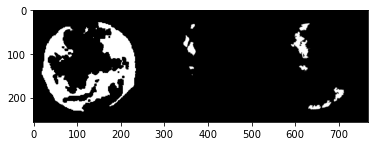

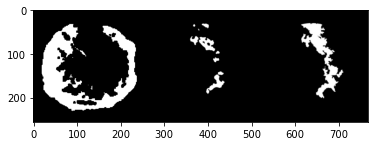

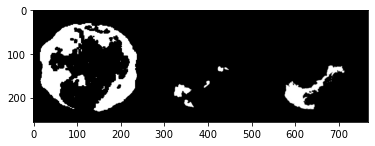

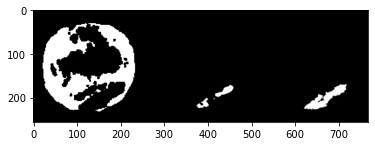

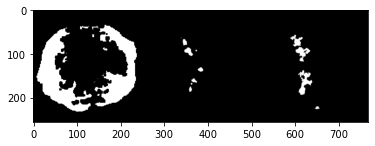

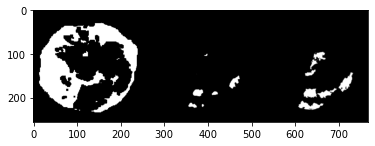

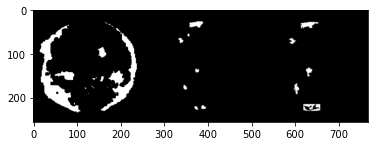

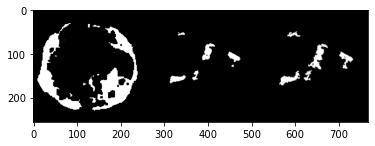

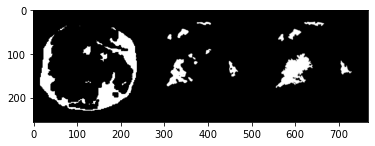

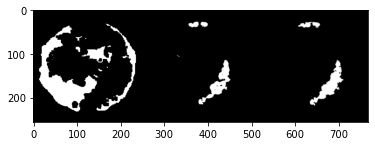

In [92]:
for i, (img, img_mask) in enumerate(zip(image_loader, mask_loader)):
    image_original_ = imageio.imread(imge_folder + "/" + img)
    image_original_mask = imageio.imread(mask_folder + "/" + img_mask)

    image_original = resize(image_original_.copy(), (256, 256))
    image_original_mask = resize(image_original_mask.copy(), (256, 256))
    
    image_original_ = color.gray2rgb(image_original_)
    image = prepare(image_original_)
    s_t = time.time()
    output = model(image.to(device))
    e_t = time.time()
    time_test = round(e_t - s_t, 10)
    output, out_vis = seg_post_process(output)
    
    ## Prepare for image visualization
    output = resize(output, (256, 256))
    output_vis = resize(out_vis, (256, 256))
    
    ## Write results
    image_original = color.gray2rgb(image_original)
    output = color.gray2rgb(output)
    image_original_mask = color.gray2rgb(image_original_mask)
    result = np.concatenate([image_original, output, image_original_mask], axis=1)
    imageio.imwrite(out_folder + "/merge/" + img, result)
    imageio.imwrite(out_folder + "/masks/" + img, output)
    plt.figure()
    plt.imshow(result)
    print("Process image {}, inference time: {}s".format(i+1, time_test))
    time_ += time_test
    
    # To limite th number of plot to 10
    if i>8:
        break


print("Images: {}".format(i+1))
print("Mean execution time: {}s".format(round(time_/(5), 4)))
print("Total execution time: {}s".format(time_))